In [1]:
#stl
import os
import warnings
from tqdm import tqdm

#data handling
import pandas as pd
import numpy as np

#stats|
import scipy
import sklearn
#import missingno as mso

#network
import networkx as nx

#vis
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
sns.set_theme()

In [2]:
!ls

adj.npy   Exploratory Data Analysis.ipynb  Main.ipynb
data.csv  install_stgnn_requirements.sh    noisy_data.csv


## Data Preprocessing

In [7]:
data = pd.read_csv("noisy_data.csv", index_col = [0])
data = data.dropna()
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,col991,col992,col993,col994,col995,col996,col997,col998,col999,col1000
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,0.852833,0.199872,1.305918,0.240586,1.110007,0.283177,-1.081762,-1.205237,0.509409,-0.379171
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,-0.997003,0.173328,-0.445139,-1.310044,0.311098,0.915465,1.158629,0.767974,0.715197,-2.560679
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,0.086464,0.452948,-0.591320,0.360759,1.871935,-0.976589,0.258499,0.485978,-2.654849,-1.554225
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,0.161176,-1.642784,1.800538,-1.019694,0.476026,0.627778,0.630856,-0.756010,-1.950746,-0.318124
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,1.505186,0.699880,-1.026447,0.386970,0.892581,2.939536,-1.650367,0.192516,-1.259063,-1.835732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,1.056567,0.852819,2.022750,-0.706946,0.544385,-0.400406,-0.440918,0.027367,-0.869499,-0.215304
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,-0.060029,0.785781,-0.566616,2.219090,0.049668,-1.311635,-0.021600,0.171000,0.898725,-0.850062
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,-0.567636,0.558397,0.440743,-1.275684,0.702258,-0.009045,-1.317783,-0.000936,1.557629,1.338373
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,1.028779,-0.721200,-1.291891,1.470140,-1.497687,-0.164757,-0.858049,0.477969,0.324310,-0.646673


In [8]:
data["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

** let us use the mean features as similarity metrics **

In [9]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean',
       ...
       'col991', 'col992', 'col993', 'col994', 'col995', 'col996', 'col997',
       'col998', 'col999', 'col1000'],
      dtype='object', length=1032)

In [10]:
from scipy.spatial.distance import pdist, squareform


edge_data = data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']].to_numpy()

#using gaussian kernel
# exp(- |x - x'|^2 / std^2)
pairwise_dists = squareform(pdist(edge_data, 'euclidean'))
gauss_kern = np.exp(-pairwise_dists ** 2 / pairwise_dists.std() ** 2)
gauss_kern[0]

array([1.00000000e+00, 4.04891410e-01, 7.04536318e-01, 3.87662076e-02,
       4.72226753e-01, 9.44063775e-02, 9.86219983e-01, 2.14351005e-01,
       1.36560438e-01, 9.33582616e-02, 6.99217086e-01, 6.58801524e-01,
       8.78284085e-01, 6.62310146e-01, 2.15284206e-01, 3.64493156e-01,
       4.21568215e-01, 7.03131170e-01, 5.62719589e-01, 1.96716867e-01,
       1.36747422e-01, 1.05419633e-02, 4.69741343e-01, 2.48756267e-01,
       9.21388190e-01, 9.34869330e-01, 3.35861077e-01, 9.27965624e-01,
       5.36805100e-01, 9.81459328e-01, 9.35586378e-01, 6.70589863e-02,
       9.13163119e-01, 7.99325519e-01, 7.23508331e-01, 8.60486637e-01,
       3.11637952e-01, 1.40744225e-01, 4.54377021e-01, 1.86482647e-01,
       1.91601935e-01, 3.28867756e-02, 9.11448959e-01, 1.67397412e-01,
       1.49988242e-01, 9.52627503e-01, 4.07890194e-03, 1.53890181e-01,
       7.28794378e-02, 1.88807165e-01, 5.91156688e-02, 2.04805714e-01,
       6.50454881e-02, 9.90646462e-01, 4.88369144e-01, 4.89400598e-02,
      

In [11]:
G = nx.from_numpy_matrix(gauss_kern)
G.remove_edges_from(nx.selfloop_edges(G))
print("nodes:", len(G.nodes))
print("edges:", len(G.edges))

nodes: 569
edges: 161596


len: 161596
top 35 percent of edges: 64638.4
range (min, max): (1.9613509166359726e-21, 0.9999979130941485)
mean: 0.5192807450904305
std: 0.38050678097822654


Text(0.5, 1.0, 'Distribution of all Edges')

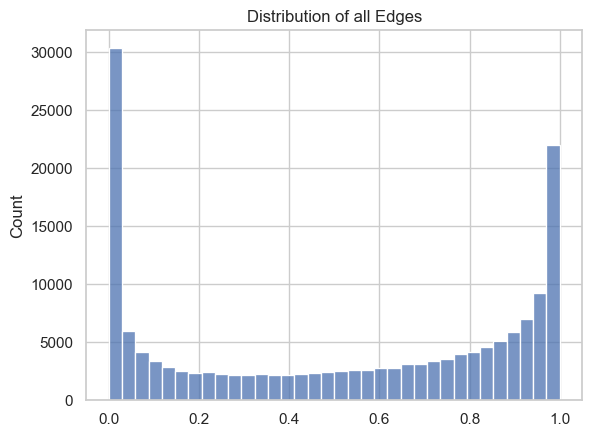

In [12]:
edge_val = [attrs["weight"] for a, b, attrs in G.edges(data=True)]
print("len:", len(edge_val))


percentage = 0.40

print("top 35 percent of edges: %s" % (percentage * len(edge_val)))

print("range (min, max): (%s, %s)" % (min(edge_val), max(edge_val)))
print("mean: %s" % (sum(edge_val) / len(edge_val)))
print("std: %s" % np.array(edge_val).std())


sns.set_style('whitegrid')
sns.histplot(edge_val)
plt.title("Distribution of all Edges")

In [13]:
ALL_edges = sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
TOP_edges = ALL_edges[(161596 - int(percentage * 161596)):]
len(TOP_edges)

64638

len: 64638
range (min, max): (0.7407234100966549, 0.9999979130941485)
mean: 0.9148869024585812
std: 0.07666023944406453


Text(0.5, 1.0, 'Distribution of Top 35% Edges')

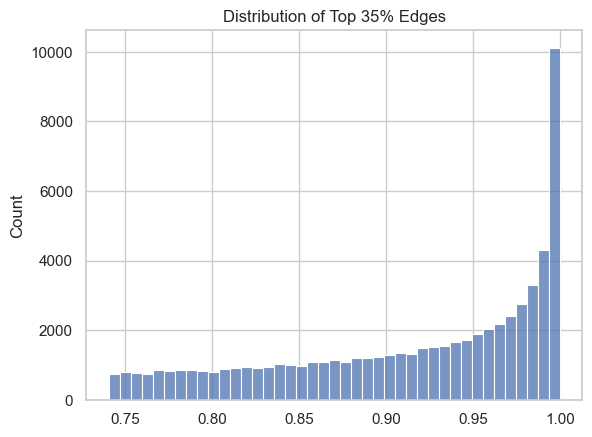

In [14]:
TOP_edge_val = [attrs["weight"] for a, b, attrs in TOP_edges]
print("len:", len(TOP_edge_val))

print("range (min, max): (%s, %s)" % (min(TOP_edge_val), max(TOP_edge_val)))
print("mean: %s" % (sum(TOP_edge_val) / len(TOP_edge_val)))
print("std: %s" % np.array(TOP_edge_val).std())

sns.set_style('whitegrid')
sns.histplot(TOP_edge_val)
plt.title("Distribution of Top 35% Edges")

In [15]:
#remove edges
remove_edges = [i for i in ALL_edges if i not in TOP_edges]
G.remove_edges_from(remove_edges)
print("nodes:", len(G.nodes))
print("edges:", len(G.edges))

nodes: 569
edges: 64638


In [ ]:
#VISUALIZE


# fig = plt.figure(figsize=(8, 8))
# # Create a gridspec for adding subplots of different sizes
# axgrid = fig.add_gridspec(5, 4)

# ax = fig.add_subplot(axgrid[0:3, :])
# pos = nx.spring_layout(G, seed=10396953)
# nx.draw_networkx_nodes(G, pos, node_size=20)
# nx.draw_networkx_edges(G, pos, alpha=0.4)
# ax.set_title("Connected Components of Top 35% of Edges")
# ax.set_axis_off()

** network completed! **

## Training Preparation

In [39]:
#np.save("adj", adj)
#adj = np.load("adj.npy")

Text(0.5, 1.0, 'Sparsity of Adjacency Matrix')

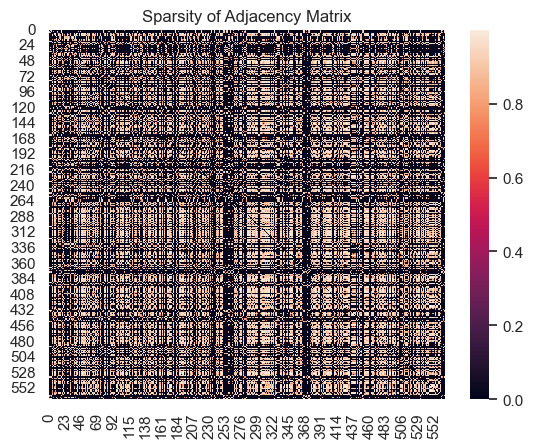

In [16]:
#get adjacency matrix --> DGL
nodes = list(G.nodes)
adj = nx.to_numpy_array(G, nodelist=nodes)
sns.heatmap(adj)
plt.title("Sparsity of Adjacency Matrix")

In [17]:
di_G = nx.from_numpy_matrix(adj, create_using = nx.DiGraph)

In [18]:
import torch
from dgl import from_networkx


#this preserves the edge weights, represents an undirected graph
dgl_G = from_networkx(di_G, edge_attrs = ["weight"])

In [19]:
dgl_G

Graph(num_nodes=569, num_edges=129276,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

In [20]:
dgl_G.edata["weight"]

tensor([0.9862, 0.8783, 0.9214,  ..., 0.8426, 0.8619, 0.9315])

In [21]:
#node labels
filter_ = {"B": 0, "M": 1}
data = data.replace({"diagnosis": filter_})

y_label = data["diagnosis"].to_list()
dgl_G.ndata["label"] = torch.from_numpy(np.array(y_label))

In [22]:
#node features
dgl_G.ndata["x"] = torch.from_numpy(data[data.columns[2:]].to_numpy())

In [23]:
#graph preprocessing done!
dgl_G

Graph(num_nodes=569, num_edges=129276,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'x': Scheme(shape=(1030,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

## Model Building - Joint Fusion with MLP + GNN (node classification with DGL)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import dgl
from dgl.nn.pytorch import GATConv
from dgl import DGLGraph
import time

In [25]:
class GAT(nn.Module):
    def __init__(self, in_feats, h_feats, GAT_heads, num_GAT_layers = 1):
        """
        ARGS:
            in_feats are the dim of input features
            h_feats are the dim of hidden layers
            GAT_heads are num of attention heads
            num_GAT_layers are the num of GAT hidden layers (excluding input/output)
        
        """
        
        super(GAT, self).__init__()
    
        self.GAT_input = GATConv(in_feats, 
                                  h_feats, num_heads = GAT_heads, 
                                  allow_zero_in_degree = True)
        
        self.GAT_layers = nn.ModuleList([GATConv(h_feats * GAT_heads, 
                                                 h_feats, 
                                                 num_heads = GAT_heads, 
                                                 allow_zero_in_degree = True) 
                                         for i in range(num_GAT_layers)])

        self.GAT_output = GATConv(h_feats * GAT_heads, 
                                  h_feats, num_heads = 1, 
                                  allow_zero_in_degree = True)

        
        
    def forward(self, g: dgl.DGLGraph, in_feat: torch.Tensor) -> any:
        
        #GAT input layer
        h = self.GAT_input(g, in_feat)
        h = F.relu(h)
        h = torch.reshape(h, (in_feat.shape[0],-1) )
        
        #inner layers
        if len(self.GAT_layers) > 0:
            for layer in self.GAT_layers:
                h = layer(g, h)
                h = F.relu(h)
                h = torch.reshape(h, (in_feat.shape[0],-1) )
        
        #GAT output layer
        h = torch.reshape(h, (in_feat.shape[0],-1) )
        h = self.GAT_output(g, h)
        
        #return final representation
        return h

In [26]:
class MLP(nn.Module):
    def __init__(self, in_feats, h_feats, num_layers = 1):
        """
        ARGS:
            in_feats are the dimension of input features
            h_feats are the dimension of hidden layers
            num_layers are the number of the hidden layers
        """
        super(MLP, self).__init__()
        
        self.input_lin = Linear(in_features = in_feats, out_features = h_feats) 
        
        self.lins = nn.ModuleList([Linear(in_features = h_feats, out_features = h_feats) 
                                   for i in range(num_layers)])

    def forward(self, in_feat):
        
        h = self.input_lin(in_feat)
        
        #iterate through the layers
        for layer in self.lins:
            h = layer(h)
            h = F.relu(h)
        
        #return final representation
        return h        

In [27]:
class Joint_Fusion(torch.nn.Module):
    def __init__(self,
                 in_feats, 
                 GNN_hfeats, 
                 GNN_layers, 
                 MLP_hfeats, 
                 MLP_layers, 
                 classifier_layers, 
                 classifier_hfeats, 
                 num_classes = 1):
        
        super(Joint_Fusion, self).__init__()
        
        self.GNN = GAT(in_feats = in_feats, h_feats = GNN_hfeats, 
                       GAT_heads = 8, num_GAT_layers = GNN_layers)
        
        self.MLP = MLP(in_feats = in_feats, h_feats = MLP_hfeats, num_layers = MLP_layers)
        
        self.classifiers = nn.ModuleList([Linear(in_features = GNN_hfeats + MLP_hfeats, 
                                                 out_features = classifier_hfeats) 
                                          for i in range(classifier_layers)])
        
        self.output_layer = Linear(in_features = classifier_hfeats, out_features = num_classes)

        
        
    def forward(self, g, in_feat):
        
        GNN_feats = self.GNN(g, in_feat)
        MLP_feats = self.MLP(in_feat)
        
        #concatenate the representation
        GNN_feats = GNN_feats.squeeze()
        combined = torch.cat([GNN_feats, MLP_feats], dim=1)
        
        #run through classifier
        for classifier_layer in self.classifiers:
            h = classifier_layer(combined)
            h = F.relu(h)
            
        #output, binary classification
        h = self.output_layer(h)
        return h      

## Train/Test Preparation

In [28]:
node_index, y_label, node_features = dgl_G.nodes(), np.array(dgl_G.ndata["label"]), np.array(dgl_G.ndata["x"])

print("shape of the node index: %s" % node_index.size())
print("shape of labels: %s" % str(y_label.shape))
print("shape of features: %s" % str(node_features.shape))

shape of the node index: 569
shape of labels: (569,)
shape of features: (569, 1030)


In [29]:
input_dim = node_features.shape[1]
print("length of input: %s" % input_dim)

length of input: 1030


In [30]:
dgl_G.edata

{'weight': tensor([0.9862, 0.8783, 0.9214,  ..., 0.8426, 0.8619, 0.9315])}

In [47]:
model_list = [
                Joint_Fusion(in_feats = input_dim,    #input node features
                             GNN_hfeats = 100,         #GNN hidden dim 
                             GNN_layers = 5,          #GNN hidden layers
                             MLP_hfeats = 50,         #MLP hidden dim
                             MLP_layers = 10,         #MLP hidden layers
                             classifier_layers = 10,   #classifier hidden layers
                             classifier_hfeats = 300, #classifier hidden dim
                             num_classes = 1) 
                for i in range(5)]

In [48]:
model_list[0]

Joint_Fusion(
  (GNN): GAT(
    (GAT_input): GATConv(
      (fc): Linear(in_features=1030, out_features=800, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (GAT_layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=800, out_features=800, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
      (1): GATConv(
        (fc): Linear(in_features=800, out_features=800, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
      )
      (2): GATConv(
        (fc): Linear(in_features=800, out_features=800, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
     

## Model Training - 5-fold Stratified CV

mean of each fold is the metrics

In [49]:
!nvidia-smi

Tue Mar  7 21:52:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P6000        On   | 00000000:04:00.0 Off |                  Off |
|124%   34C    P8    17W / 250W |   3391MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        On   | 00000000:05:00.0 Off |                  Off |
|127%   

In [50]:
device = "cuda:0"

In [51]:
from dgl.nn import AvgPooling, GNNExplainer


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [54]:
print("\n----------------------------------------------------------------------------")


#new data split with new seed
skf = StratifiedKFold(n_splits=5, shuffle = True)

accuracy = []
f_1 = []
precision = []
recall = []
probs_list = []
auc_list = []

#for each of the 5 splits
model_count = 0

for index, (train_index, test_index) in enumerate(skf.split(node_index, y_label)):

    #print(train_index[0:5], test_index[0:5])
    x_train_index, y_label_train = node_index[train_index], y_label[train_index]
    x_test_index, y_label_test = node_index[test_index], y_label[test_index]

    #one hot encode the labels
    y_label_train, y_label_test = [float(i) for i in y_label_train], \
                                  [float(i) for i in y_label_test]

    #create blank masks with all false
    train_mask, test_mask = [False for i in range(len(node_index))], \
                            [False for i in range(len(node_index))]

    #fill masks with true
    #x train index is a list of indexes that should be included for training
    for i in x_train_index:
        train_mask[i] = True
    for i in x_test_index:
        test_mask[i] = True

    #get everything ready for training
    device = "cuda:0"
    dgl_G = dgl_G.int().to(device)
    
    #labels are in (y_label_train, y_label_test)
    dgl_G.ndata["train_mask"] = torch.from_numpy(np.array(train_mask)).to(device)
    dgl_G.ndata["test_mask"] = torch.from_numpy(np.array(test_mask)).to(device)

    #labels to tensors
    y_label_train = torch.from_numpy(np.array(y_label_train)).to(device)
    y_label_test = torch.from_numpy(np.array(y_label_test)).to(device)

    #get indexes of train, test, val
    train_index = torch.nonzero(dgl_G.ndata["train_mask"]).squeeze()
    test_index = torch.nonzero(dgl_G.ndata["test_mask"]).squeeze()


    features = dgl_G.ndata["x"].float().to(device)
    train_mask = dgl_G.ndata["train_mask"].to(device)
    test_mask = dgl_G.ndata["test_mask"].to(device)
    train_index = train_index.to(device)
    test_index = test_index.to(device)

    model = model_list[model_count].to(device)

    #class weight raises the error of a certain class to account for imbalanced class types
    #pos_weight = 1
    #CHANGE THIS PARAMETER AS YOU SEE FIT
    pos_weight = [1.]

    #hyperparamters
    num_epochs = 50
    lr = 3e-3
    l2_wd = 5e-4

    #loss functions
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor(pos_weight)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
    #validation loss

    model.train()
    epoch = 0
    prev_val_loss = 1e10
    threshold = 0.5

    for i in tqdm(range(num_epochs), desc = "fold training"):

        #get the predictions
        logits = model(dgl_G, features) 
        logits = logits
        loss = loss_fn(logits[train_index], y_label_train.unsqueeze(-1))

        #loss = loss_fn(logits[train_index], y_label_train.unsqueeze(-1)) # USE FOR GCN

        #get the probability of whole thing
        probs = torch.sigmoid(logits.detach()).cpu().numpy()
        #set a threshold and round it
        preds = (probs >= threshold).astype(int)
        
        #training acc
        train_acc = accuracy_score(y_true = y_label_train.cpu(), y_pred = preds[train_index.cpu()])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()


    accuracy.append(accuracy_score(y_true = y_label_test.cpu(), y_pred = preds[test_index.cpu()]))
    f_1.append(f1_score(y_true = y_label_test.cpu(), y_pred = preds[test_index.cpu()]))
    precision.append(precision_score(y_true = y_label_test.cpu(), y_pred = preds[test_index.cpu()]))
    recall.append(recall_score(y_true = y_label_test.cpu(), y_pred = preds[test_index.cpu()]))
    probs_list.append(probs)
    auc_list.append(roc_auc_score(y_true = y_label_test.cpu(), y_score = preds[test_index.cpu()]))

    model_count += 1


----------------------------------------------------------------------------


fold training: 100%|██████████| 50/50 [00:01<00:00, 28.27it/s]


## Calculating Accuracy!

In [55]:
acc_df = pd.DataFrame([accuracy, auc_list, f_1, precision, recall]).T
acc_df.index = ["Fold %s" % str(i + 1) for i in range(5)]
acc_df.columns = ["ACC", "AUC", "F1", "Precision", "Recall"]
acc_df.loc["AVG"] = acc_df.mean(axis = 0)
acc_df

,ACC,AUC,F1,Precision,Recall
Fold 1,0.973684,0.969702,0.964706,0.976190,0.953488
Fold 2,0.973684,0.965116,0.963855,1.000000,0.930233
Fold 3,0.973684,0.969246,0.963855,0.975610,0.952381
Fold 4,0.973684,0.969246,0.963855,0.975610,0.952381
Fold 5,0.920354,0.907445,0.888889,0.923077,0.857143
AVG,0.963018,0.956151,0.949032,0.970097,0.929125
